# Continuous Time Inference (Burgers)

This is a version used for development, getting information, and for generating graphs.

Based on:

- https://github.com/maziarraissi/PINNs/blob/master/appendix/continuous_time_inference%20(Burgers)/Burgers.py
- https://people.sc.fsu.edu/~jburkardt/f_src/burgers_solution/burgers_solution.html

Environment setup:

    conda create -yn tf1 ipykernel python=3.7
    conda activate tf1
    conda install -yc conda-forge tensorflow=1.15 matplotlib pyDOE

Import TensofFlow v1.15:

In [1]:
import tensorflow as tf
print(tf.__version__)

1.15.0


Disable TensorFlow logging output :

In [2]:
import logging, os
logging.disable(logging.WARNING)
logging.getLogger('tensorflow').disabled = True
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [4]:
import scipy.io
from scipy.interpolate import griddata

- [pyDOE](https://pythonhosted.org/pyDOE/randomized.html#latin-hypercube)
(includes the Latin-Hypercube)

In [5]:
from pyDOE import lhs

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [7]:
import numpy as np
import time

In [8]:
np.set_printoptions(linewidth=132, precision=6)

Try to make the result reproducible:

In [9]:
np.random.seed(1234)
tf.compat.v1.set_random_seed(1234)

## Data

In [10]:
# DATA_BURGERS = '../Data/burgers_shock.mat'
# DIR_FIGURES  = './figures/Burgers'
DATA_BURGERS = 'RAISSI/appendix/Data/burgers_shock.mat'
DIR_FIGURES  = 'RAISSI/appendix/continuous_time_inference (Burgers)/figures/Burgers'

In [11]:
data  = scipy.io.loadmat(DATA_BURGERS)
Exact = np.real(data['usol']).T

In [12]:
Exact.shape

(100, 256)

In [13]:
t = data['t'].flatten()[:, None]
x = data['x'].flatten()[:, None]

In [14]:
t.shape

(100, 1)

NT = 100

In [15]:
x.shape

(256, 1)

NX = 256

In [16]:
data['usol'].shape

(256, 100)

In [17]:
data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Sep 20 16:38:22 2017',
 '__version__': '1.0',
 '__globals__': [],
 'x': array([[-1.      ],
        [-0.992157],
        [-0.984314],
        [-0.976471],
        [-0.968627],
        [-0.960784],
        [-0.952941],
        [-0.945098],
        [-0.937255],
        [-0.929412],
        [-0.921569],
        [-0.913725],
        [-0.905882],
        [-0.898039],
        [-0.890196],
        [-0.882353],
        [-0.87451 ],
        [-0.866667],
        [-0.858824],
        [-0.85098 ],
        [-0.843137],
        [-0.835294],
        [-0.827451],
        [-0.819608],
        [-0.811765],
        [-0.803922],
        [-0.796078],
        [-0.788235],
        [-0.780392],
        [-0.772549],
        [-0.764706],
        [-0.756863],
        [-0.74902 ],
        [-0.741176],
        [-0.733333],
        [-0.72549 ],
        [-0.717647],
        [-0.709804],
        [-0.701961],
        [-0.694118],
        [-0.686275]

In [18]:
Exact[0:5,5:10].T

array([[0.122888, 0.119137, 0.115608, 0.112283, 0.109144],
       [0.147302, 0.142819, 0.138601, 0.134624, 0.13087 ],
       [0.171626, 0.166422, 0.161523, 0.156904, 0.15254 ],
       [0.195845, 0.189933, 0.184364, 0.17911 , 0.174145],
       [0.219946, 0.213338, 0.207111, 0.201233, 0.195676]])

In [19]:
Exact.T.shape

(256, 100)

## Plotting module

In [20]:
# mpl.use('pgf')


def figsize(scale, nplots=1):
    fig_width_pt = 390.0  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0 / 72.27  # Convert pt to inch

    # Aesthetic ratio (you could change this)
    golden_mean = (np.sqrt(5.0) - 1.0) / 2.0

    fig_width = fig_width_pt * inches_per_pt * scale  # width in inches
    fig_height = nplots * fig_width * golden_mean  # height in inches
    fig_size = [fig_width, fig_height]
    return fig_size


##setup matplotlib to use latex for output
pgf_with_latex = {
    ##change this if using xetex or latex
    "pgf.texsystem": "pdflatex",
    ##use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    ##blank entries should cause plots to inherit fonts from the document
    "font.serif": [],
    "font.sans-serif": [],
    "font.monospace": [],
    ##LaTeX default is 10pt font.
    "axes.labelsize": 10,
    "font.size": 10,
    ##Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    ##default fig size of 0.9 textwidth
    "figure.figsize": figsize(1.0),
    "pgf.preamble": [
        ##use utf8 fonts becasue your computer can handle it :)
        #r"\usepackage[utf8x]{inputenc}",
        ##plots will be generated using this preamble
        r"\usepackage[T1]{fontenc}"]}

plt.rcParams.update(pgf_with_latex)

import matplotlib.pyplot as plt


# I make my own savefig functions
def savefig(filename, crop=True):
    if crop == True:
        # plt.savefig('{}.pgf'.format(filename),
        #             bbox_inches='tight',
        #             pad_inches=0)
        plt.savefig('{}.pdf'.format(filename),
                    bbox_inches='tight',
                    pad_inches=0)
        plt.savefig('{}.eps'.format(filename),
                    bbox_inches='tight',
                    pad_inches=0)
    else:
        # plt.savefig('{}.pgf'.format(filename))
        plt.savefig('{}.pdf'.format(filename))
        plt.savefig('{}.eps'.format(filename))

## PINN code

In [21]:
class PhysicsInformedNN:

    def __init__(self, X_u, u, X_f, layers, lb, ub, nu):
        self.lb = lb
        self.ub = ub
        self.x_u = X_u[:, 0:1]
        self.t_u = X_u[:, 1:2]
        self.x_f = X_f[:, 0:1]
        self.t_f = X_f[:, 1:2]
        self.u = u
        self.layers = layers
        self.nu = nu

        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        self.x_u_tf = tf.placeholder(tf.float32,
                                     shape=[None, self.x_u.shape[1]])
        self.t_u_tf = tf.placeholder(tf.float32,
                                     shape=[None, self.t_u.shape[1]])
        self.u_tf   = tf.placeholder(tf.float32,
                                     shape=[None, self.u.shape[1]])
        self.x_f_tf = tf.placeholder(tf.float32,
                                     shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32,
                                     shape=[None, self.t_f.shape[1]])

#========================================

        self.u_pred = self.net_u(self.x_u_tf, self.t_u_tf)
        self.f_pred = self.net_f(self.x_f_tf, self.t_f_tf)
        
#========================================

        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_pred))
    
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(
            self.loss,
            method='L-BFGS-B',
            options={
                'maxiter': 50000,
                'maxfun': 50000,
                'maxcor': 50,
                'maxls': 50,
                'ftol': 1.0 * np.finfo(float).eps
            })
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32),
                            dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim],
                                               stddev=xavier_stddev),
                           dtype=tf.float32)

    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

#========================================

    def net_u(self, x, t):
        u = self.neural_net(tf.concat([x, t], 1), self.weights, self.biases)
        return u

    def net_f(self, x, t):
        u = self.net_u(x, t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        f = u_t + u * u_x - self.nu * u_xx
        return f

#===================================

    def callback(self, loss):
        print('Loss:', loss)

    def train(self):
        tf_dict = {
            self.x_u_tf: self.x_u,
            self.t_u_tf: self.t_u,
            self.u_tf: self.u,
            self.x_f_tf: self.x_f,
            self.t_f_tf: self.t_f
        }
        self.optimizer.minimize(self.sess,
                                feed_dict=tf_dict,
                                fetches=[self.loss],
                                loss_callback=self.callback)

    def predict(self, X_star):
        u_star = self.sess.run(self.u_pred, {
            self.x_u_tf: X_star[:, 0:1],
            self.t_u_tf: X_star[:, 1:2]
        })
        f_star = self.sess.run(self.f_pred, {
            self.x_f_tf: X_star[:, 0:1],
            self.t_f_tf: X_star[:, 1:2]
        })
        return u_star, f_star

## Main

In [24]:
nu = 0.01 / np.pi
N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat(DATA_BURGERS)

t = data['t'].flatten()[:, None]
x = data['x'].flatten()[:, None]
Exact = np.real(data['usol']).T  # Exact
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()[:, None]  # Exact

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)

xx1 = np.hstack((X[0:1, :].T, T[0:1, :].T))
xx2 = np.hstack((X[:, 0:1], T[:, 0:1]))
xx3 = np.hstack((X[:, -1:], T[:, -1:]))
X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub - lb) * lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]

# Exact
uu1 = Exact[0:1, :].T
uu2 = Exact[:, 0:1]
uu3 = Exact[:, -1:]
u_train = np.vstack([uu1, uu2, uu3])
u_train = u_train[idx, :]  # Exact

In [23]:
X_star

array([[-1.      ,  0.      ],
       [-0.992157,  0.      ],
       [-0.984314,  0.      ],
       ...,
       [ 0.984314,  0.99    ],
       [ 0.992157,  0.99    ],
       [ 1.      ,  0.99    ]])

## Model

In [25]:
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1
truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:GPU:0
truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
truncated_normal: (Add): /job:localhost/replica:0/task:0/device:GPU:0
Variable: (VariableV2): /job:localhost/replica:0/task:0/device:GPU:0
Variable/Assign: (Assign): /job:localhost/replica:0/task:0/device:GPU:0
Vari

In [26]:
model.summary()

AttributeError: 'PhysicsInformedNN' object has no attribute 'summary'

## Compute intensive part

In [22]:
%%time
history = model.train()

Loss: 0.28520367
Loss: 0.6429156
Loss: 0.25300646
Loss: 0.23689014
Loss: 0.23533319
Loss: 0.23134337
Loss: 0.22981523
Loss: 0.22796476
Loss: 0.2209417
Loss: 0.21882923
Loss: 0.21366796
Loss: 0.2044886
Loss: 0.19408083
Loss: 0.19082892
Loss: 0.21186388
Loss: 0.18022718
Loss: 0.17486876
Loss: 0.16278088
Loss: 0.15494536
Loss: 0.15105024
Loss: 0.15107971
Loss: 0.14876308
Loss: 0.14753973
Loss: 0.14399533
Loss: 0.14016522
Loss: 0.13778645
Loss: 0.19103637
Loss: 0.1332493
Loss: 0.12933572
Loss: 0.117080644
Loss: 0.11714523
Loss: 0.107980594
Loss: 0.12277792
Loss: 0.10553017
Loss: 0.103317976
Loss: 0.10231427
Loss: 0.101673074
Loss: 0.10049983
Loss: 0.09788458
Loss: 0.096559316
Loss: 0.09338131
Loss: 0.09248124
Loss: 0.09212844
Loss: 0.09199354
Loss: 0.09101771
Loss: 0.08899912
Loss: 0.088003285
Loss: 0.087535724
Loss: 0.08715896
Loss: 0.08692296
Loss: 0.086795606
Loss: 0.08649542
Loss: 0.086109236
Loss: 0.08547158
Loss: 0.08483908
Loss: 0.08437598
Loss: 0.08410807
Loss: 0.083900616
Loss: 0.

## Predict

In [23]:
%%time
u_pred, f_pred = model.predict(X_star)

CPU times: user 447 ms, sys: 46.7 ms, total: 494 ms
Wall time: 206 ms


Execute 1000 times

In [34]:
tf.compat.v1.disable_eager_execution()

In [35]:
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

In [32]:
%%time
for _ in range(1000):
    u_pred, f_pred = model.predict(X_star)

CPU times: user 4min 49s, sys: 31.2 s, total: 5min 20s
Wall time: 41.1 s


In [45]:
from tensorflow.python.client import device_lib

In [47]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2923436430830131260
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11599902078979644742
physical_device_desc: "device: XLA_CPU device"
]


In [50]:
tf.test.is_gpu_available()

False

In [51]:
tf.test.gpu_device_name()

''

In [53]:
tf.debugging.set_log_device_placement(True)

In [56]:
with tf.device('/GPU:0'):
    u_pred, f_pred = model.predict(X_star)

In [61]:
! numactl -C 1 echo oi

oi


In [59]:
%%time
! numactl -C 1
for _ in range(300):
    u_pred, f_pred = model.predict(X_star)

usage: numactl [--all | -a] [--interleave= | -i <nodes>] [--preferred= | -p <node>]
               [--physcpubind= | -C <cpus>] [--cpunodebind= | -N <nodes>]
               [--membind= | -m <nodes>] [--localalloc | -l] command args ...
       numactl [--show | -s]
       numactl [--hardware | -H]
       numactl [--length | -l <length>] [--offset | -o <offset>] [--shmmode | -M <shmmode>]
               [--strict | -t]
               [--shmid | -I <id>] --shm | -S <shmkeyfile>
               [--shmid | -I <id>] --file | -f <tmpfsfile>
               [--huge | -u] [--touch | -T] 
               memory policy | --dump | -d | --dump-nodes | -D

memory policy is --interleave | -i, --preferred | -p, --membind | -m, --localalloc | -l
<nodes> is a comma delimited list of node numbers or A-B ranges or all.
Instead of a number a node can also be:
  netdev:DEV the node connected to network device DEV
  file:PATH  the node the block device of path is connected to
  ip:HOST    the node of the networ

## Error u

In [24]:
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
print('Error u: %e' % (error_u))

Error u: 1.621288e-03


## Save data

In [25]:
np.save('data_history.npy', history)
np.save('data_u_pred.npy', u_pred)
np.save('data_f_pred.npy', f_pred)

---

## Load data

In [22]:
history = np.load('data_history.npy', allow_pickle=True)
u_pred = np.load('data_u_pred.npy', allow_pickle=True)
f_pred = np.load('data_f_pred.npy', allow_pickle=True)

## Error

In [23]:
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

## Plotting

## $u(t,x)$ graph

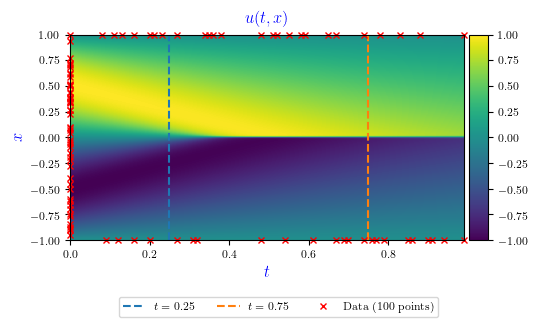

In [73]:
WIDTH = 1.0  # width in inches.
NPLOTS = 0.8  # height in inches.
fig = plt.figure(figsize=figsize(WIDTH, NPLOTS))
ax = fig.add_subplot(111)  # (nrows=1, ncols=1, index=1)

h = ax.imshow(U_pred.T,
              extent=[t.min(), t.max(), x.min(),
                      x.max()],
              aspect='auto')

# right side bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

# add vertical lines
line = np.linspace(x.min(), x.max(), 2)[:, None]
ax.plot(t[25] * np.ones((2, 1)), line, '--', label="$t = 0.25$")
ax.plot(t[75] * np.ones((2, 1)), line, '--', label="$t = 0.75$")

# plot the axis marks
ax.plot(X_u_train[:, 1],
        X_u_train[:, 0],
        'rx',
        label='Data (%d points)' % (u_train.shape[0]),
        markersize=4,
        clip_on=False)
# message inside the figure, on the right side
#ax.legend()

# title and labels
font = {'size': 'large', 'weight': 'bold', 'color': 'blue'}
# bottom vertical alignment for more space
ax.set_title('$u(t,x)$', verticalalignment='bottom', **font)
ax.set_xlabel('$t$', **font)
ax.set_ylabel('$x$', **font)

ax.legend(bbox_to_anchor=(.95, -.25), ncol=4)

plt.show()

## $u(t,x)$ slices

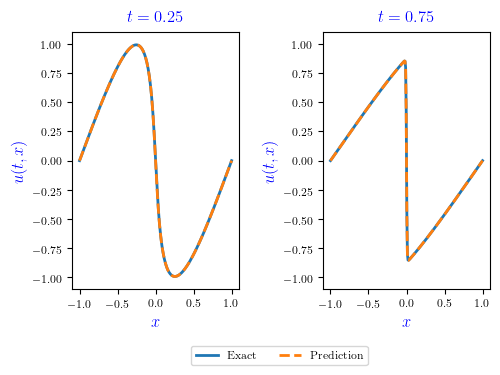

In [67]:
font = {'size': 'large', 'weight': 'bold', 'color': 'blue'}
gs = gridspec.GridSpec(1, 2, wspace=.5)

ax = plt.subplot(gs[0, 0])
ax.plot(x, Exact[25, :], '-', linewidth = 2, label='Exact')
ax.plot(x, U_pred[25, :], '--', linewidth = 2, label='Prediction')
ax.set_title('$t=0.25$', verticalalignment='bottom', **font)
ax.set_xlabel('$x$', **font)
ax.set_ylabel('$u(t,x)$', **font)
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])

ax = plt.subplot(gs[0, 1])
ax.plot(x, Exact[75, :], '-', linewidth = 2, label='Exact')
ax.plot(x, U_pred[75, :], '--', linewidth = 2, label='Prediction')
ax.set_title('$t=0.75$', verticalalignment='bottom', **font)
ax.set_xlabel('$x$', **font)
ax.set_ylabel('$u(t,x)$', **font)
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])

ax.legend(bbox_to_anchor=(0.3, -0.2), ncol=2)

plt.show()